# Import Packages

In [1]:
!nvidia-smi

Unable to determine the device handle for GPU 0000:01:00.0: Unknown Error


In [2]:
# !pip install torchviz

In [3]:
import my_utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cxs49vni because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [7]:
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
from AutomaticWeightedLoss import AutomaticWeightedLoss

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Global Variables

In [11]:
## Global Variables

# DEVICE: GPU
DEVICE = torch.device("cuda", 0)

# DataFrame 檔案路徑
TRAIN_DF_FILE_PATH = "./data/NTU_DATA_train_split.csv"
VALID_DF_FILE_PATH = "./data/NTU_DATA_valid_split.csv"
TEST_DF_FILE_PATH = "./data/NTU_DATA_test_split.csv"

# BERT Embedding Tensor 儲存與載入的檔案路徑
TRAIN_EMBEDDING_FILE_PATH = "./data/NTU_DATA_train_embedding.pt"
VALID_EMBEDDING_FILE_PATH = "./data/NTU_DATA_valid_embedding.pt"
TEST_EMBEDDING_FILE_PATH = "./data/NTU_DATA_test_embedding.pt"

# Save the experiment results (Grid Searching)
# EXPERIMENT_FILE_PATH = f"./results/result.txt"

# BERT Tokenizer
TOKENIZER = BertTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")

# BERT Model
BERT = BertModel.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
BERT.to(DEVICE)

# Model Settings
EPOCHS = 300
PATIENCE = 50
########################
LR_MODEL = 5e-6 # 5e-6
BATCH_SIZE = 64  # 64
### Multi-task Weighting
ALPHA = 0.0
TAU = 0.0
########################
LABEL_COLUMN = "Sentiment"
LABEL_MAPPING = {"neutral": 0, "negative": 1, "positive": 2}
MAPPING = {'neutral': 0, 'negative': 1, 'positive': 2, 
           'apology': 0, 'quotation': 1, 'acknowledge': 2, 
           'thanking': 3, 'question': 4, 'disagreement': 5, 
           'greeting': 6, 'reject': 7, 'conventional-closing': 8, 
           'interjection': 9, 'agreement': 10, 'answer': 11, 
           'comfort': 12, 'command': 13, 'irony': 14, 
           'statement-non-opinion': 15, 'statement-opinion': 16, 'appreciation': 17, 
           'other': 18, 'low': 0.0, 'high': 1.0, '語者一': 0, '語者二': 1}
TASKS = ["main_loss"]  #  "future_DA_loss", "sentiment_loss", "DA_loss"

FINETUNED_MODEL_PATH = "./finetuned_model.ckpt"
PRETRAINED_MODEL_PATH = "./multitask_final_model.ckpt"

# # NTU_DATA Finetune
# WITH_TRAINING = True

# NTU_DATA Test Directly
WITH_TRAINING = False

# # NTU_DATA Train from scratch
# WITH_TRAINING = True
# PRETRAINED_MODEL_PATH = None
# EPOCHS = 300
# PATIENCE = 50
# LR_MODEL = 5e-6
# BATCH_SIZE = 64

Some weights of the model checkpoint at IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
my_utils.set_seed()

**** The seed has been initialized ****


# Load Dataset

In [13]:
# Data Sample
df_temp = pd.read_csv(TRAIN_DF_FILE_PATH)
df_temp.head(10)

,Dialogue_ID,Utterance_ID,Speaker,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Sentiment,DA,Utterance
0,dialogue-0000,dialogue-0000-000,語者一,high,high,high,high,high,negative,other,您好，不好意思系統這裡沒有查到您的訂位資訊
1,dialogue-0000,dialogue-0000-001,語者一,high,high,high,high,high,neutral,other,想請問您昨天是否有接到訂位確認的電話呢？
2,dialogue-0000,dialogue-0000-002,語者二,high,high,high,high,high,neutral,other,你好，我沒有接到電話欸
3,dialogue-0000,dialogue-0000-003,語者二,high,high,high,high,high,neutral,other,但我確定我上週有在 inline 上訂位呀
4,dialogue-0000,dialogue-0000-004,語者一,high,high,high,high,high,neutral,other,還是您有沒有可能是訂錯時間了呢？
5,dialogue-0000,dialogue-0000-005,語者二,high,high,high,high,high,neutral,other,我確認一下
6,dialogue-0000,dialogue-0000-006,語者二,high,high,high,high,high,negative,other,好怪為啥網站上寫我的訂位被取消了
7,dialogue-0000,dialogue-0000-007,語者二,high,high,high,high,high,negative,other,但我訂的時間是現在沒有錯啊
8,dialogue-0000,dialogue-0000-008,語者一,high,high,high,high,high,neutral,other,那應該是因為您沒有接到確認電話
9,dialogue-0000,dialogue-0000-009,語者一,high,high,high,high,high,neutral,other,我們的規定是如果沒有接到電話的話就會自動取消訂位


In [14]:
# # Data Sample
# df_temp_1 = pd.read_csv(TRAIN_DF_FILE_PATH)
# df_temp_2 = pd.read_csv(VALID_DF_FILE_PATH)
# df_temp_3 = pd.read_csv(TEST_DF_FILE_PATH)
# x = df_temp_1.Dialogue_ID.unique().tolist() + df_temp_2.Dialogue_ID.unique().tolist() + df_temp_3.Dialogue_ID.unique().tolist()
# len(x)

In [15]:
df_temp.Extraversion.value_counts()

high    8459
Name: Extraversion, dtype: int64

In [16]:
train_df = my_utils.load_df(TRAIN_DF_FILE_PATH)
valid_df = my_utils.load_df(VALID_DF_FILE_PATH)
test_df = my_utils.load_df(TEST_DF_FILE_PATH)

The shape of the Dataset: (8459, 11)
The number of dialogues: 336
     Dialogue_ID       Utterance_ID Speaker Neuroticism Extraversion Openness  \
0  dialogue-0000  dialogue-0000-000     語者一        high         high     high   
1  dialogue-0000  dialogue-0000-001     語者一        high         high     high   
2  dialogue-0000  dialogue-0000-002     語者二        high         high     high   
3  dialogue-0000  dialogue-0000-003     語者二        high         high     high   
4  dialogue-0000  dialogue-0000-004     語者一        high         high     high   

  Agreeableness Conscientiousness Sentiment     DA              Utterance  
0          high              high  negative  other  您好，不好意思系統這裡沒有查到您的訂位資訊  
1          high              high   neutral  other   想請問您昨天是否有接到訂位確認的電話呢？  
2          high              high   neutral  other            你好，我沒有接到電話欸  
3          high              high   neutral  other  但我確定我上週有在 inline 上訂位呀  
4          high              high   neutral  other       還是您有沒有可能是訂

# Generate Training Data

In [17]:
train_df, train_mapping = my_utils.get_dialogues_df(train_df, LABEL_COLUMN, MAPPING, MAPPING)
valid_df, valid_mapping = my_utils.get_dialogues_df(valid_df, LABEL_COLUMN, MAPPING, MAPPING)
test_df, test_mapping = my_utils.get_dialogues_df(test_df, LABEL_COLUMN, MAPPING, MAPPING)

100%|██████████| 336/336 [00:07<00:00, 42.20it/s]


The shape of the Dialogue DataFrame: (2452, 3)


100%|██████████| 48/48 [00:01<00:00, 45.62it/s]


The shape of the Dialogue DataFrame: (338, 3)


100%|██████████| 96/96 [00:02<00:00, 32.79it/s]

The shape of the Dialogue DataFrame: (690, 3)


In [18]:
# Assert the mappings between all dataset are the same
assert MAPPING == train_mapping == valid_mapping == test_mapping

In [19]:
print(MAPPING)

{'neutral': 0, 'negative': 1, 'positive': 2, 'apology': 0, 'quotation': 1, 'acknowledge': 2, 'thanking': 3, 'question': 4, 'disagreement': 5, 'greeting': 6, 'reject': 7, 'conventional-closing': 8, 'interjection': 9, 'agreement': 10, 'answer': 11, 'comfort': 12, 'command': 13, 'irony': 14, 'statement-non-opinion': 15, 'statement-opinion': 16, 'appreciation': 17, 'other': 18, 'low': 0.0, 'high': 1.0, '語者一': 0, '語者二': 1}


In [20]:
# test_df.labels.value_counts()

In [21]:
train_df.head()

,context,labels,demo
0,"[語者一：您好，不好意思系統這裡沒有查到您的訂位資訊, 語者一：想請問您昨天是否有接到訂位確...","{'main_label': 0, 'future_DA_label': 18, 'sent...",那應該是因為您沒有接到確認電話
1,"[語者一：你好，我沒有接到電話欸, 語者一：但我確定我上週有在 inline 上訂位呀, 語...","{'main_label': 1, 'future_DA_label': 18, 'sent...",但我就只是剛好沒接到電話而已欸
2,"[語者一：但我確定我上週有在 inline 上訂位呀, 語者二：還是您有沒有可能是訂錯時間了...","{'main_label': 1, 'future_DA_label': 18, 'sent...",不好意思，因為這是公司的規定，我們也沒辦法
3,"[語者一：還是您有沒有可能是訂錯時間了呢？, 語者二：我確認一下, 語者二：好怪為啥網站上寫...","{'main_label': 0, 'future_DA_label': 18, 'sent...",那這樣現在現場還有座位嗎
4,"[語者一：我確認一下, 語者一：好怪為啥網站上寫我的訂位被取消了, 語者一：但我訂的時間是現...","{'main_label': 0, 'future_DA_label': 18, 'sent...",目前現場候位都已經滿了哦


In [22]:
# 確保所有文本長度一致
print(min([len(x) for x in train_df.context]))
assert min([len(x) for x in train_df.context]) == max([len(x) for x in train_df.context])

8


In [23]:
print("Train Data's Label Distribution:")
print(train_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)
print("Valid Data's Label Distribution:")
print(valid_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)
print("Test Data's Label Distribution:")
print(test_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)

Train Data's Label Distribution:
0    1033
1     900
2     519
Name: labels, dtype: int64
Valid Data's Label Distribution:
1    138
0    133
2     67
Name: labels, dtype: int64
Test Data's Label Distribution:
0    281
1    253
2    156
Name: labels, dtype: int64


In [24]:
for i in range(3):
    print(train_df.context[i])
    print(train_df.labels[i])
    print("="*70)

['語者一：您好，不好意思系統這裡沒有查到您的訂位資訊', '語者一：想請問您昨天是否有接到訂位確認的電話呢？', '語者二：你好，我沒有接到電話欸', '語者二：但我確定我上週有在 inline 上訂位呀', '語者一：還是您有沒有可能是訂錯時間了呢？', '語者二：我確認一下', '語者二：好怪為啥網站上寫我的訂位被取消了', '語者二：但我訂的時間是現在沒有錯啊']
{'main_label': 0, 'future_DA_label': 18, 'sentiment_labels': [1, 0, 0, 0, 0, 0, 1, 1], 'DA_labels': [18, 18, 18, 18, 18, 18, 18, 18], 'big_five_labels': {'語者一': [1.0, 1.0, 1.0, 1.0, 1.0], '語者二': [1.0, 1.0, 1.0, 1.0, 1.0]}, 'speaking_order': [0, 0, 1, 1, 0, 1, 1, 1]}
['語者一：你好，我沒有接到電話欸', '語者一：但我確定我上週有在 inline 上訂位呀', '語者二：還是您有沒有可能是訂錯時間了呢？', '語者一：我確認一下', '語者一：好怪為啥網站上寫我的訂位被取消了', '語者一：但我訂的時間是現在沒有錯啊', '語者二：那應該是因為您沒有接到確認電話', '語者二：我們的規定是如果沒有接到電話的話就會自動取消訂位']
{'main_label': 1, 'future_DA_label': 18, 'sentiment_labels': [0, 0, 0, 0, 1, 1, 0, 0], 'DA_labels': [18, 18, 18, 18, 18, 18, 18, 18], 'big_five_labels': {'語者一': [1.0, 1.0, 1.0, 1.0, 1.0], '語者二': [1.0, 1.0, 1.0, 1.0, 1.0]}, 'speaking_order': [0, 0, 1, 0, 0, 0, 1, 1]}
['語者一：但我確定我上週有在 inline 上訂位呀', '語者二：還是您有沒有可能是訂錯時間了呢？', '語者一：我確認一下', '語者一：好怪為啥網站上寫我的訂位被取消了', '

In [25]:
# total_length = 0
# total_count = 0
# for each in test_df["context"]:
#     total_length += len(each)
#     total_count += 1
# print(total_length)

# total_length = 0
# total_count = 0
# for each in test_df["context"]:
#     for u in each:
#         total_count += 1
#         total_length += len(u)
# print((total_length / total_count) - 4)

# max_lengthhh = 0
# for each in test_df["context"]:
#     for u in each:
#         if len(u) > max_lengthhh:
#             max_lengthhh = len(u)
# print(max_lengthhh - 4)

# total_da = 0
# total_count = 0
# for each in valid_df["labels"]:
#     total_count += 1
#     total_da += len(set(each["DA_labels"]))
# print(total_da / total_count)

In [27]:
total_length = 0
total_count = 0
for each in train_df["context"]:
    for u in each:
        total_count += 1
        total_length += len(u)
for each in test_df["context"]:
    for u in each:
        total_count += 1
        total_length += len(u)
print((total_length / total_count) - 4)

10.991446530872055


# Calculate Embedding

In [25]:
# # Comment these lines if we do not need to calculate the embeddings again
# train_embedding = my_utils.get_dialogues_embedding(train_df, TOKENIZER, BERT, DEVICE, TRAIN_EMBEDDING_FILE_PATH)
# valid_embedding = my_utils.get_dialogues_embedding(valid_df, TOKENIZER, BERT, DEVICE, VALID_EMBEDDING_FILE_PATH)
# test_embedding = my_utils.get_dialogues_embedding(test_df, TOKENIZER, BERT, DEVICE, TEST_EMBEDDING_FILE_PATH)

In [26]:
# 100%|██████████| 5124/5124 [12:48<00:00,  6.67it/s]
# 100%|██████████| 600/600 [01:30<00:00,  6.66it/s]
# 100%|██████████| 1544/1544 [03:51<00:00,  6.68it/s]

# 100%|██████████| 1756/1756 [04:12<00:00,  6.95it/s]
# 100%|██████████| 256/256 [00:36<00:00,  7.00it/s]
# 100%|██████████| 506/506 [01:12<00:00,  7.02it/s]

# 100%|██████████| 2452/2452 [07:02<00:00,  5.80it/s]
# 100%|██████████| 338/338 [01:17<00:00,  4.34it/s]
# 100%|██████████| 690/690 [02:30<00:00,  4.59it/s]

In [27]:
# Load the Embeddings
train_embedding = torch.load(TRAIN_EMBEDDING_FILE_PATH)
print(train_embedding.shape)
valid_embedding = torch.load(VALID_EMBEDDING_FILE_PATH)
print(valid_embedding.shape)
test_embedding = torch.load(TEST_EMBEDDING_FILE_PATH)
print(test_embedding.shape)

torch.Size([2452, 8, 768])
torch.Size([338, 8, 768])
torch.Size([690, 8, 768])


# Model Training

In [28]:
class Dataset(Dataset):
    def __init__(self, df, embeddings):
        self.embeddings = embeddings
        self.main_labels = torch.tensor(df.labels.apply(lambda x: x["main_label"]))
        self.future_DA_labels = torch.tensor(df.labels.apply(lambda x: x["future_DA_label"]))
        self.sentiment_labels = torch.tensor(df.labels.apply(lambda x: x["sentiment_labels"]))
        self.DA_labels = torch.tensor(df.labels.apply(lambda x: x["DA_labels"]))
        self.speaker1_labels = torch.tensor(df.labels.apply(lambda x: x["big_five_labels"]["語者一"]))
        self.speaker2_labels = torch.tensor(df.labels.apply(lambda x: x["big_five_labels"]["語者二"]))
        self.speaking_order = torch.tensor(df.labels.apply(lambda x: x["speaking_order"]))

    def __len__(self):
        assert self.main_labels.shape[0] == self.embeddings.shape[0]
        return self.main_labels.shape[0]

    def __getitem__(self, idx):
        embeddings = self.embeddings[idx]
        main_labels = self.main_labels[idx]
        future_DA_labels = self.future_DA_labels[idx]
        sentiment_labels = self.sentiment_labels[idx]
        DA_labels = self.DA_labels[idx]
        speaker1_labels = self.speaker1_labels[idx]
        speaker2_labels = self.speaker2_labels[idx]
        speaking_order = self.speaking_order[idx]
        return embeddings, main_labels, future_DA_labels, sentiment_labels, DA_labels, speaker1_labels, speaker2_labels, speaking_order

In [29]:
class Model(nn.Module):
    def __init__(self):   
        super(Model, self).__init__()  # head = 2 or 4 or 8
        self.speaker_emb = nn.Embedding(2, 768)
        self.contextual_attention_layer = nn.MultiheadAttention(768, num_heads=8, batch_first=True, dropout=0.0)  # 0.3 > 0.7
#         self.gru_layer = nn.GRU(768, 768, batch_first=True, bidirectional=False)
        self.layer_norm = nn.LayerNorm(768)
        self.fc = nn.Linear(768, 128)
        self.relu_1 = nn.ReLU()
        self.last_attention_layer = nn.MultiheadAttention(128, num_heads=4, batch_first=True, dropout=0.0)  # 0.1 > 0.3
        self.relu_2 = nn.ReLU()
        self.main_module = nn.Sequential(
            nn.Linear(128, len(LABEL_MAPPING)), # LABEL_NUM classes for main task prediction
        )
        self.future_DA_module = nn.Sequential(
            nn.Linear(128, 19),
        )
        self.sentiment_module = nn.Sequential(
            nn.Linear(128, 3),
        )
        self.DA_module = nn.Sequential(
            nn.Linear(128, 19),
        )
        self.big_five_module = nn.Sequential(
            nn.Linear(128, 5),
        )
        
    def forward(self, embeddings, speaking_order):
        speaker_embeddings = self.speaker_emb(speaking_order)
        embeddings = embeddings + speaker_embeddings
        output, _ = self.contextual_attention_layer(embeddings, embeddings, embeddings)  # output shape: (batch_size, seq_length, hidden_dim)
#         output, _ = self.gru_layer(embeddings)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.relu_1(output)
        # Sentiment output
        sentiment_output = self.sentiment_module(output)  # output shape: (batch_size, seq_length, num_classes)
        # DA output
        DA_output = self.DA_module(output)  # output shape: (batch_size, seq_length, num_classes)
        # Big five output
        speaker1_output = torch.zeros(output.shape[0], output.shape[2]).to(DEVICE)
        speaker2_output = torch.zeros(output.shape[0], output.shape[2]).to(DEVICE)
        # Average over time steps for Speaker 1 and Speaker 2
        for i in range(output.shape[0]):
            s1 = torch.mean(output[i, speaking_order[i] == 0, :], dim=0).to(DEVICE)
            s2 = torch.mean(output[i, speaking_order[i] == 1, :], dim=0).to(DEVICE)
            speaker1_output[i] = s1
            speaker2_output[i] = s2
        speaker1_output = self.big_five_module(speaker1_output)  # output shape: (batch_size, 5)
        speaker2_output = self.big_five_module(speaker2_output)  # output shape: (batch_size, 5)
#         1. concatenated_output = torch.cat((pooled_output, last_output), dim=1)
#         2. pooled_output, last_output = torch.mean(output, dim=1), output[:, -1, :]
#         2. output = pooled_output + last_output
        output, _ = self.last_attention_layer(output[:, -1:, :], output, output)
        output = output.squeeze(1)
        output = self.relu_2(output)
        # Future DA output
        future_DA_output = self.future_DA_module(output)  # output shape: (batch_size, num_classes)
        # Main output
        main_output = self.main_module(output)  # output shape: (batch_size, num_classes) for sentiment prediction
        return main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output

In [30]:
def train(lr_model=LR_MODEL, batch_size=BATCH_SIZE, tasks=TASKS, alpha=ALPHA, tau=TAU, pretrained_model_path=PRETRAINED_MODEL_PATH, verbose=True):
    
    # Training Record
    train_loss_dict = {}
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    
    # Validation Record
    valid_loss_dict = {}
    valid_accuracy_list = []
    valid_precision_list = []
    valid_recall_list = []
    valid_f1_list = []
    
    # Training and Valid Dataset
    train = Dataset(df=train_df, embeddings=train_embedding)
    valid = Dataset(df=valid_df, embeddings=valid_embedding)
    
    # Training and Valid DataLoader
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    # Model
    model = Model()
    model = model.to(DEVICE)
    
    # Load pretrained weights
    if pretrained_model_path:
        
        # Load weight for DaNN
        pretrained_dict = torch.load(pretrained_model_path)
        model_dict = model.state_dict()
        # 1. filter out unnecessary keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        print("="*50)
        print(pretrained_dict.keys())
        print("="*50)
        # 2. overwrite entries in the existing state dict
        model_dict.update(pretrained_dict) 
        # 3. load the new state dict
        model.load_state_dict(model_dict)
        
        # Freeze parameters
        model.speaker_emb.requires_grad_(False)

    # Loss Weights
#     if len(tasks) > 1:
#         awl = AutomaticWeightedLoss(num=len(tasks))
#         awl = awl.to(DEVICE)
    
    # Optimizer
    optimizer_model = torch.optim.Adam(model.parameters(), lr=lr_model)
#     if len(tasks) > 1:
#         optimizer_loss = torch.optim.Adam(awl.parameters(), weight_decay=0, lr=lr_loss)
    
    # LR Scheduler
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer_model, num_warmup_steps=int(total_steps*0.03), num_training_steps=total_steps)

    # Dynamic Loss Weight
    t_tau = int(len(train_dataloader) * tau)
    T = len(train_dataloader)
    
    # Early Stopping
    trigger_times = 0
    best_f1 = float("-inf")
    
    # Training with epochs
    for epoch_num in range(EPOCHS):
        
        # Set the state of the model to "Training"
        model.train()
        
        # To save the training result
        train_loss = {}
        train_true = torch.tensor([])
        train_pred = torch.tensor([])
        
        first_batch_loss_dict = None
        
        # Training with batches
        for t, (train_embeddings, train_main_labels, train_future_DA_labels, train_sentiment_labels, train_DA_labels, train_speaker1_labels, train_speaker2_labels, train_speaking_order) in enumerate(tqdm(train_dataloader, disable=(not verbose))):
            
            # Current step (Start from 1)
            # t = t + 1
            
            # Feed the data into the model
            train_embeddings = train_embeddings.to(DEVICE)
            train_main_labels = train_main_labels.to(DEVICE)
            train_future_DA_labels = train_future_DA_labels.to(DEVICE)
            train_sentiment_labels = train_sentiment_labels.to(DEVICE)
            train_DA_labels = train_DA_labels.to(DEVICE)
            train_speaker1_labels = train_speaker1_labels.to(DEVICE)
            train_speaker2_labels = train_speaker2_labels.to(DEVICE)
            train_speaking_order = train_speaking_order.to(DEVICE)
            
            optimizer_model.zero_grad()
#             if len(tasks) > 1:
#                 optimizer_loss.zero_grad()
            
            main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output = model(train_embeddings, train_speaking_order)
            
            # Reshape sequence output and labels
            sentiment_output = sentiment_output.view(-1, 3)
            train_sentiment_labels = train_sentiment_labels.view(-1)
            
            # Reshape sequence output and labels
            DA_output = DA_output.view(-1, 19)
            train_DA_labels = train_DA_labels.view(-1)
            
            loss_dict = my_utils.multi_task_loss(
                main_output, 
                future_DA_output,
                sentiment_output, 
                DA_output, 
                speaker1_output, 
                speaker2_output, 
                train_main_labels, 
                train_future_DA_labels,
                train_sentiment_labels, 
                train_DA_labels, 
                train_speaker1_labels, 
                train_speaker2_labels,
            )
            
            if len(tasks) == 1:
                loss = loss_dict["total_loss"]
            else:
                if t == 0:
                    first_batch_loss_dict = loss_dict.copy()
                mu = t / t_tau if t <= t_tau else 1.0  # (t / T)
                losses = [loss_dict["main_loss"],]
                weights = [mu,]
                for task_name in tasks:
                    if task_name == "main_loss":
                        continue
                    else:
                        task_loss = loss_dict[task_name]
                        first_batch_task_loss = first_batch_loss_dict[task_name]
                        lambda_ = (task_loss.item() / first_batch_task_loss.item()) ** alpha
                        lambda_ = ((t_tau - t) / t_tau) * lambda_ if t <= t_tau else 0.0
                        losses.append(task_loss)
                        weights.append(lambda_)
                assert len(losses) == len(weights)
                losses_tensor = torch.stack(losses).to(DEVICE)
                weights_tensor = torch.tensor(weights).to(DEVICE)
                weighted_losses = losses_tensor * weights_tensor
                loss = torch.sum(weighted_losses)
                loss_dict["total_loss"] = loss
                    
#             else:
#                 target_losses = [loss_dict[key] for key in tasks]
#                 loss = awl(*target_losses)
#                 loss_dict["total_loss"] = loss
            
            loss.backward()
            
            optimizer_model.step()
            scheduler.step()
            
#             if len(tasks) > 1:
#                 optimizer_loss.step()
            
            # Calculate Score
            train_main_labels = train_main_labels.cpu()
            main_output = torch.argmax(main_output, dim=-1).cpu()
            
            # Get the results and save them
            for loss_type, loss_value in loss_dict.items():
                if loss_type not in train_loss:
                    train_loss[loss_type] = loss_value.item()
                else:
                    train_loss[loss_type] += loss_value.item()
    
            train_true = torch.cat([train_true, train_main_labels])
            train_pred = torch.cat([train_pred, main_output])
            
        # Calculate Metrics
        train_accuracy = accuracy_score(train_true, train_pred)
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')
        
        for loss_type, loss_value in train_loss.items():
            train_loss[loss_type] = loss_value / len(train_dataloader)
             
        # cal avg train loss and acc
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        
        for loss_type, loss_value in train_loss.items():
            if loss_type not in train_loss_dict:
                train_loss_dict[loss_type] = [loss_value,]
            else:
                train_loss_dict[loss_type].append(loss_value)
        
        # ===============================================================================
        
        # Set the state of the model to "Evaluation"
        model.eval()
        
        # To save the validation result
        valid_loss = {}
        valid_true = torch.tensor([])
        valid_pred = torch.tensor([])
        
        # Validation
        with torch.no_grad():
            
            # Validation with batches
            for valid_embeddings, valid_main_labels, valid_future_DA_labels, valid_sentiment_labels, valid_DA_labels, valid_speaker1_labels, valid_speaker2_labels, valid_speaking_order in tqdm(valid_dataloader, disable=(not verbose)):
                
                # Feed the data into the model
                valid_embeddings = valid_embeddings.to(DEVICE)
                valid_main_labels = valid_main_labels.to(DEVICE)
                valid_future_DA_labels = valid_future_DA_labels.to(DEVICE)
                valid_sentiment_labels = valid_sentiment_labels.to(DEVICE)
                valid_DA_labels = valid_DA_labels.to(DEVICE)
                valid_speaker1_labels = valid_speaker1_labels.to(DEVICE)
                valid_speaker2_labels = valid_speaker2_labels.to(DEVICE)
                valid_speaking_order = valid_speaking_order.to(DEVICE)
                
                main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output = model(valid_embeddings, valid_speaking_order)
                
                # Reshape sequence output and labels
                sentiment_output = sentiment_output.view(-1, 3)
                valid_sentiment_labels = valid_sentiment_labels.view(-1)
                
                # Reshape sequence output and labels
                DA_output = DA_output.view(-1, 19)
                valid_DA_labels = valid_DA_labels.view(-1)
                
                loss_dict = my_utils.multi_task_loss(
                    main_output, 
                    future_DA_output,
                    sentiment_output, 
                    DA_output, 
                    speaker1_output, 
                    speaker2_output, 
                    valid_main_labels,
                    valid_future_DA_labels,
                    valid_sentiment_labels, 
                    valid_DA_labels, 
                    valid_speaker1_labels, 
                    valid_speaker2_labels,
                )
                
                if len(tasks) == 1:
                    loss = loss_dict["total_loss"]
#                 else:
#                     target_losses = [loss_dict[key] for key in tasks]
#                     loss = awl(*target_losses)
#                     loss_dict["total_loss"] = loss

                # Calculate Score
                valid_main_labels = valid_main_labels.cpu()
                main_output = torch.argmax(main_output, dim=-1).cpu()

                # Get the results and save them
                for loss_type, loss_value in loss_dict.items():
                    if loss_type not in valid_loss:
                        valid_loss[loss_type] = loss_value.item()
                    else:
                        valid_loss[loss_type] += loss_value.item()
                        
                valid_true = torch.cat([valid_true, valid_main_labels])
                valid_pred = torch.cat([valid_pred, main_output])

        # Calculate Metrics
        valid_accuracy = accuracy_score(valid_true, valid_pred)
        valid_precision = precision_score(valid_true, valid_pred, average='macro')
        valid_recall = recall_score(valid_true, valid_pred, average='macro')
        valid_f1 = f1_score(valid_true, valid_pred, average='macro')
        
        for loss_type, loss_value in valid_loss.items():
            valid_loss[loss_type] = loss_value / len(valid_dataloader)
             
        # cal avg val loss and acc
        valid_accuracy_list.append(valid_accuracy)
        valid_precision_list.append(valid_precision)
        valid_recall_list.append(valid_recall)
        valid_f1_list.append(valid_f1)
        
        for loss_type, loss_value in valid_loss.items():
            if loss_type not in valid_loss_dict:
                valid_loss_dict[loss_type] = [loss_value,]
            else:
                valid_loss_dict[loss_type].append(loss_value)
        
        if verbose:
            # Print the result of each epoch
            print(
                f"Epochs: {epoch_num + 1} \
                | Train Loss: {train_loss['total_loss']: .3f} | Train F1: {train_f1: .3f} | Train Precision: {train_precision: .3f} | Train Recall: {train_recall: .3f} \
                | Valid Loss: {valid_loss['total_loss']: .3f} | Valid F1: {valid_f1: .3f} | Valid Precision: {valid_precision: .3f} | Valid Recall: {valid_recall: .3f}")
            # print(awl.params)
        
        # Early Stopping
        if valid_f1 <= best_f1:
            trigger_times += 1
            if verbose:
                print('Trigger times:', trigger_times)

            if trigger_times > PATIENCE:
                if verbose:
                    print('Early stopping! Start the test process.')
                break
        else:
            if verbose:
                print('Trigger times: 0')
            trigger_times = 0
            best_f1 = valid_f1
            torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
        
    return model, train_precision_list, valid_precision_list, train_recall_list, valid_recall_list, \
            train_f1_list, valid_f1_list, train_loss_dict, valid_loss_dict

In [31]:
%%time
model, train_precision_list, valid_precision_list, train_recall_list, valid_recall_list, \
    train_f1_list, valid_f1_list, train_loss_dict, valid_loss_dict = train()

dict_keys(['speaker_emb.weight', 'contextual_attention_layer.in_proj_weight', 'contextual_attention_layer.in_proj_bias', 'contextual_attention_layer.out_proj.weight', 'contextual_attention_layer.out_proj.bias', 'layer_norm.weight', 'layer_norm.bias', 'fc.weight', 'fc.bias', 'last_attention_layer.in_proj_weight', 'last_attention_layer.in_proj_bias', 'last_attention_layer.out_proj.weight', 'last_attention_layer.out_proj.bias', 'main_module.0.weight', 'main_module.0.bias', 'future_DA_module.0.weight', 'future_DA_module.0.bias', 'sentiment_module.0.weight', 'sentiment_module.0.bias', 'DA_module.0.weight', 'DA_module.0.bias', 'big_five_module.0.weight', 'big_five_module.0.bias'])


100%|██████████| 6/6 [00:00<00:00, 60.23it/s]


Epochs: 1                 | Train Loss:  1.099 | Train F1:  0.394 | Train Precision:  0.458 | Train Recall:  0.411                 | Valid Loss:  1.131 | Valid F1:  0.375 | Valid Precision:  0.396 | Valid Recall:  0.382
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.45it/s]


Epochs: 2                 | Train Loss:  1.053 | Train F1:  0.407 | Train Precision:  0.456 | Train Recall:  0.413                 | Valid Loss:  1.094 | Valid F1:  0.366 | Valid Precision:  0.385 | Valid Recall:  0.373
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 59.97it/s]


Epochs: 3                 | Train Loss:  1.025 | Train F1:  0.401 | Train Precision:  0.444 | Train Recall:  0.407                 | Valid Loss:  1.083 | Valid F1:  0.361 | Valid Precision:  0.371 | Valid Recall:  0.379
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 60.20it/s]


Epochs: 4                 | Train Loss:  1.019 | Train F1:  0.401 | Train Precision:  0.451 | Train Recall:  0.410                 | Valid Loss:  1.074 | Valid F1:  0.353 | Valid Precision:  0.358 | Valid Recall:  0.374
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 59.94it/s]


Epochs: 5                 | Train Loss:  1.011 | Train F1:  0.415 | Train Precision:  0.468 | Train Recall:  0.420                 | Valid Loss:  1.063 | Valid F1:  0.374 | Valid Precision:  0.400 | Valid Recall:  0.386
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 60.08it/s]


Epochs: 6                 | Train Loss:  0.998 | Train F1:  0.437 | Train Precision:  0.481 | Train Recall:  0.435                 | Valid Loss:  1.053 | Valid F1:  0.403 | Valid Precision:  0.435 | Valid Recall:  0.408
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.12it/s]


Epochs: 7                 | Train Loss:  0.991 | Train F1:  0.442 | Train Precision:  0.494 | Train Recall:  0.440                 | Valid Loss:  1.045 | Valid F1:  0.428 | Valid Precision:  0.455 | Valid Recall:  0.426
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.20it/s]


Epochs: 8                 | Train Loss:  0.984 | Train F1:  0.458 | Train Precision:  0.505 | Train Recall:  0.453                 | Valid Loss:  1.040 | Valid F1:  0.433 | Valid Precision:  0.460 | Valid Recall:  0.431
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.26it/s]


Epochs: 9                 | Train Loss:  0.975 | Train F1:  0.468 | Train Precision:  0.506 | Train Recall:  0.461                 | Valid Loss:  1.035 | Valid F1:  0.437 | Valid Precision:  0.455 | Valid Recall:  0.434
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.16it/s]


Epochs: 10                 | Train Loss:  0.970 | Train F1:  0.475 | Train Precision:  0.515 | Train Recall:  0.468                 | Valid Loss:  1.033 | Valid F1:  0.434 | Valid Precision:  0.444 | Valid Recall:  0.431
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 60.12it/s]


Epochs: 11                 | Train Loss:  0.962 | Train F1:  0.494 | Train Precision:  0.523 | Train Recall:  0.486                 | Valid Loss:  1.033 | Valid F1:  0.427 | Valid Precision:  0.444 | Valid Recall:  0.424
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 59.90it/s]


Epochs: 12                 | Train Loss:  0.958 | Train F1:  0.503 | Train Precision:  0.535 | Train Recall:  0.494                 | Valid Loss:  1.029 | Valid F1:  0.440 | Valid Precision:  0.451 | Valid Recall:  0.436
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 58.98it/s]


Epochs: 13                 | Train Loss:  0.951 | Train F1:  0.508 | Train Precision:  0.541 | Train Recall:  0.499                 | Valid Loss:  1.027 | Valid F1:  0.444 | Valid Precision:  0.450 | Valid Recall:  0.441
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.13it/s]


Epochs: 14                 | Train Loss:  0.946 | Train F1:  0.513 | Train Precision:  0.533 | Train Recall:  0.506                 | Valid Loss:  1.029 | Valid F1:  0.440 | Valid Precision:  0.451 | Valid Recall:  0.436
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 59.01it/s]


Epochs: 15                 | Train Loss:  0.944 | Train F1:  0.512 | Train Precision:  0.544 | Train Recall:  0.503                 | Valid Loss:  1.029 | Valid F1:  0.438 | Valid Precision:  0.455 | Valid Recall:  0.434
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 59.38it/s]


Epochs: 16                 | Train Loss:  0.939 | Train F1:  0.518 | Train Precision:  0.544 | Train Recall:  0.509                 | Valid Loss:  1.024 | Valid F1:  0.452 | Valid Precision:  0.459 | Valid Recall:  0.449
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 59.05it/s]


Epochs: 17                 | Train Loss:  0.935 | Train F1:  0.520 | Train Precision:  0.549 | Train Recall:  0.511                 | Valid Loss:  1.022 | Valid F1:  0.447 | Valid Precision:  0.453 | Valid Recall:  0.444
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 59.80it/s]


Epochs: 18                 | Train Loss:  0.930 | Train F1:  0.529 | Train Precision:  0.555 | Train Recall:  0.520                 | Valid Loss:  1.023 | Valid F1:  0.462 | Valid Precision:  0.472 | Valid Recall:  0.458
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 59.93it/s]


Epochs: 19                 | Train Loss:  0.922 | Train F1:  0.538 | Train Precision:  0.559 | Train Recall:  0.529                 | Valid Loss:  1.024 | Valid F1:  0.484 | Valid Precision:  0.491 | Valid Recall:  0.481
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 59.03it/s]


Epochs: 20                 | Train Loss:  0.926 | Train F1:  0.533 | Train Precision:  0.564 | Train Recall:  0.524                 | Valid Loss:  1.024 | Valid F1:  0.453 | Valid Precision:  0.465 | Valid Recall:  0.448
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 59.39it/s]


Epochs: 21                 | Train Loss:  0.916 | Train F1:  0.536 | Train Precision:  0.555 | Train Recall:  0.527                 | Valid Loss:  1.024 | Valid F1:  0.445 | Valid Precision:  0.459 | Valid Recall:  0.441
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 59.84it/s]


Epochs: 22                 | Train Loss:  0.914 | Train F1:  0.538 | Train Precision:  0.566 | Train Recall:  0.528                 | Valid Loss:  1.022 | Valid F1:  0.452 | Valid Precision:  0.463 | Valid Recall:  0.448
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 60.13it/s]


Epochs: 23                 | Train Loss:  0.909 | Train F1:  0.549 | Train Precision:  0.562 | Train Recall:  0.541                 | Valid Loss:  1.025 | Valid F1:  0.461 | Valid Precision:  0.480 | Valid Recall:  0.456
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 59.96it/s]


Epochs: 24                 | Train Loss:  0.906 | Train F1:  0.550 | Train Precision:  0.578 | Train Recall:  0.539                 | Valid Loss:  1.024 | Valid F1:  0.466 | Valid Precision:  0.477 | Valid Recall:  0.461
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 60.09it/s]


Epochs: 25                 | Train Loss:  0.907 | Train F1:  0.555 | Train Precision:  0.572 | Train Recall:  0.547                 | Valid Loss:  1.025 | Valid F1:  0.463 | Valid Precision:  0.476 | Valid Recall:  0.458
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 60.06it/s]


Epochs: 26                 | Train Loss:  0.897 | Train F1:  0.557 | Train Precision:  0.578 | Train Recall:  0.547                 | Valid Loss:  1.022 | Valid F1:  0.486 | Valid Precision:  0.492 | Valid Recall:  0.484
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 59.93it/s]


Epochs: 27                 | Train Loss:  0.889 | Train F1:  0.563 | Train Precision:  0.581 | Train Recall:  0.554                 | Valid Loss:  1.023 | Valid F1:  0.472 | Valid Precision:  0.486 | Valid Recall:  0.466
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 60.02it/s]


Epochs: 28                 | Train Loss:  0.886 | Train F1:  0.565 | Train Precision:  0.587 | Train Recall:  0.555                 | Valid Loss:  1.019 | Valid F1:  0.477 | Valid Precision:  0.487 | Valid Recall:  0.473
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 60.10it/s]


Epochs: 29                 | Train Loss:  0.887 | Train F1:  0.568 | Train Precision:  0.590 | Train Recall:  0.558                 | Valid Loss:  1.020 | Valid F1:  0.483 | Valid Precision:  0.495 | Valid Recall:  0.478
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 59.97it/s]


Epochs: 30                 | Train Loss:  0.882 | Train F1:  0.572 | Train Precision:  0.590 | Train Recall:  0.562                 | Valid Loss:  1.020 | Valid F1:  0.483 | Valid Precision:  0.495 | Valid Recall:  0.478
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 60.22it/s]


Epochs: 31                 | Train Loss:  0.877 | Train F1:  0.578 | Train Precision:  0.594 | Train Recall:  0.569                 | Valid Loss:  1.020 | Valid F1:  0.488 | Valid Precision:  0.499 | Valid Recall:  0.483
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 60.27it/s]


Epochs: 32                 | Train Loss:  0.872 | Train F1:  0.583 | Train Precision:  0.604 | Train Recall:  0.573                 | Valid Loss:  1.019 | Valid F1:  0.508 | Valid Precision:  0.513 | Valid Recall:  0.506
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 59.92it/s]


Epochs: 33                 | Train Loss:  0.868 | Train F1:  0.586 | Train Precision:  0.596 | Train Recall:  0.580                 | Valid Loss:  1.021 | Valid F1:  0.483 | Valid Precision:  0.495 | Valid Recall:  0.478
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 60.06it/s]


Epochs: 34                 | Train Loss:  0.862 | Train F1:  0.590 | Train Precision:  0.612 | Train Recall:  0.579                 | Valid Loss:  1.020 | Valid F1:  0.502 | Valid Precision:  0.510 | Valid Recall:  0.498
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 58.67it/s]


Epochs: 35                 | Train Loss:  0.858 | Train F1:  0.596 | Train Precision:  0.616 | Train Recall:  0.585                 | Valid Loss:  1.022 | Valid F1:  0.497 | Valid Precision:  0.505 | Valid Recall:  0.493
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 58.88it/s]


Epochs: 36                 | Train Loss:  0.854 | Train F1:  0.597 | Train Precision:  0.613 | Train Recall:  0.588                 | Valid Loss:  1.022 | Valid F1:  0.495 | Valid Precision:  0.503 | Valid Recall:  0.490
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 58.78it/s]


Epochs: 37                 | Train Loss:  0.850 | Train F1:  0.599 | Train Precision:  0.619 | Train Recall:  0.589                 | Valid Loss:  1.023 | Valid F1:  0.495 | Valid Precision:  0.507 | Valid Recall:  0.490
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 59.39it/s]


Epochs: 38                 | Train Loss:  0.847 | Train F1:  0.599 | Train Precision:  0.619 | Train Recall:  0.588                 | Valid Loss:  1.021 | Valid F1:  0.494 | Valid Precision:  0.505 | Valid Recall:  0.490
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 60.10it/s]


Epochs: 39                 | Train Loss:  0.845 | Train F1:  0.601 | Train Precision:  0.616 | Train Recall:  0.593                 | Valid Loss:  1.022 | Valid F1:  0.499 | Valid Precision:  0.512 | Valid Recall:  0.495
Trigger times: 7


100%|██████████| 6/6 [00:00<00:00, 93.32it/s]


Epochs: 40                 | Train Loss:  0.836 | Train F1:  0.609 | Train Precision:  0.629 | Train Recall:  0.599                 | Valid Loss:  1.023 | Valid F1:  0.494 | Valid Precision:  0.502 | Valid Recall:  0.492
Trigger times: 8


100%|██████████| 6/6 [00:00<00:00, 59.33it/s]


Epochs: 41                 | Train Loss:  0.838 | Train F1:  0.610 | Train Precision:  0.628 | Train Recall:  0.600                 | Valid Loss:  1.020 | Valid F1:  0.486 | Valid Precision:  0.494 | Valid Recall:  0.483
Trigger times: 9


100%|██████████| 6/6 [00:00<00:00, 59.98it/s]


Epochs: 42                 | Train Loss:  0.827 | Train F1:  0.617 | Train Precision:  0.634 | Train Recall:  0.607                 | Valid Loss:  1.025 | Valid F1:  0.504 | Valid Precision:  0.513 | Valid Recall:  0.500
Trigger times: 10


100%|██████████| 6/6 [00:00<00:00, 60.00it/s]


Epochs: 43                 | Train Loss:  0.824 | Train F1:  0.617 | Train Precision:  0.632 | Train Recall:  0.607                 | Valid Loss:  1.023 | Valid F1:  0.502 | Valid Precision:  0.503 | Valid Recall:  0.501
Trigger times: 11


100%|██████████| 6/6 [00:00<00:00, 60.08it/s]


Epochs: 44                 | Train Loss:  0.824 | Train F1:  0.628 | Train Precision:  0.649 | Train Recall:  0.616                 | Valid Loss:  1.026 | Valid F1:  0.492 | Valid Precision:  0.500 | Valid Recall:  0.490
Trigger times: 12


100%|██████████| 6/6 [00:00<00:00, 60.05it/s]


Epochs: 45                 | Train Loss:  0.820 | Train F1:  0.625 | Train Precision:  0.639 | Train Recall:  0.616                 | Valid Loss:  1.026 | Valid F1:  0.486 | Valid Precision:  0.491 | Valid Recall:  0.483
Trigger times: 13


100%|██████████| 6/6 [00:00<00:00, 59.34it/s]


Epochs: 46                 | Train Loss:  0.812 | Train F1:  0.627 | Train Precision:  0.640 | Train Recall:  0.619                 | Valid Loss:  1.024 | Valid F1:  0.490 | Valid Precision:  0.501 | Valid Recall:  0.486
Trigger times: 14


100%|██████████| 6/6 [00:00<00:00, 59.33it/s]


Epochs: 47                 | Train Loss:  0.808 | Train F1:  0.635 | Train Precision:  0.654 | Train Recall:  0.624                 | Valid Loss:  1.026 | Valid F1:  0.489 | Valid Precision:  0.496 | Valid Recall:  0.486
Trigger times: 15


100%|██████████| 6/6 [00:00<00:00, 59.94it/s]


Epochs: 48                 | Train Loss:  0.804 | Train F1:  0.642 | Train Precision:  0.660 | Train Recall:  0.631                 | Valid Loss:  1.029 | Valid F1:  0.488 | Valid Precision:  0.492 | Valid Recall:  0.485
Trigger times: 16


100%|██████████| 6/6 [00:00<00:00, 60.16it/s]


Epochs: 49                 | Train Loss:  0.803 | Train F1:  0.635 | Train Precision:  0.649 | Train Recall:  0.626                 | Valid Loss:  1.028 | Valid F1:  0.495 | Valid Precision:  0.493 | Valid Recall:  0.499
Trigger times: 17


100%|██████████| 6/6 [00:00<00:00, 59.89it/s]


Epochs: 50                 | Train Loss:  0.798 | Train F1:  0.643 | Train Precision:  0.654 | Train Recall:  0.636                 | Valid Loss:  1.029 | Valid F1:  0.493 | Valid Precision:  0.496 | Valid Recall:  0.491
Trigger times: 18


100%|██████████| 6/6 [00:00<00:00, 59.98it/s]


Epochs: 51                 | Train Loss:  0.796 | Train F1:  0.646 | Train Precision:  0.660 | Train Recall:  0.637                 | Valid Loss:  1.035 | Valid F1:  0.473 | Valid Precision:  0.479 | Valid Recall:  0.471
Trigger times: 19


100%|██████████| 6/6 [00:00<00:00, 59.89it/s]


Epochs: 52                 | Train Loss:  0.791 | Train F1:  0.644 | Train Precision:  0.658 | Train Recall:  0.635                 | Valid Loss:  1.033 | Valid F1:  0.486 | Valid Precision:  0.491 | Valid Recall:  0.484
Trigger times: 20


100%|██████████| 6/6 [00:00<00:00, 59.96it/s]


Epochs: 53                 | Train Loss:  0.783 | Train F1:  0.648 | Train Precision:  0.664 | Train Recall:  0.639                 | Valid Loss:  1.032 | Valid F1:  0.485 | Valid Precision:  0.496 | Valid Recall:  0.480
Trigger times: 21


100%|██████████| 6/6 [00:00<00:00, 59.39it/s]


Epochs: 54                 | Train Loss:  0.782 | Train F1:  0.661 | Train Precision:  0.679 | Train Recall:  0.651                 | Valid Loss:  1.031 | Valid F1:  0.491 | Valid Precision:  0.492 | Valid Recall:  0.493
Trigger times: 22


100%|██████████| 6/6 [00:00<00:00, 55.31it/s]


Epochs: 55                 | Train Loss:  0.782 | Train F1:  0.658 | Train Precision:  0.670 | Train Recall:  0.649                 | Valid Loss:  1.034 | Valid F1:  0.492 | Valid Precision:  0.498 | Valid Recall:  0.490
Trigger times: 23


100%|██████████| 6/6 [00:00<00:00, 59.95it/s]


Epochs: 56                 | Train Loss:  0.771 | Train F1:  0.669 | Train Precision:  0.682 | Train Recall:  0.661                 | Valid Loss:  1.041 | Valid F1:  0.470 | Valid Precision:  0.482 | Valid Recall:  0.465
Trigger times: 24


100%|██████████| 6/6 [00:00<00:00, 59.14it/s]


Epochs: 57                 | Train Loss:  0.765 | Train F1:  0.665 | Train Precision:  0.680 | Train Recall:  0.656                 | Valid Loss:  1.038 | Valid F1:  0.485 | Valid Precision:  0.490 | Valid Recall:  0.481
Trigger times: 25


100%|██████████| 6/6 [00:00<00:00, 59.16it/s]


Epochs: 58                 | Train Loss:  0.760 | Train F1:  0.672 | Train Precision:  0.686 | Train Recall:  0.664                 | Valid Loss:  1.043 | Valid F1:  0.485 | Valid Precision:  0.491 | Valid Recall:  0.483
Trigger times: 26


100%|██████████| 6/6 [00:00<00:00, 58.92it/s]


Epochs: 59                 | Train Loss:  0.766 | Train F1:  0.672 | Train Precision:  0.687 | Train Recall:  0.662                 | Valid Loss:  1.044 | Valid F1:  0.484 | Valid Precision:  0.490 | Valid Recall:  0.481
Trigger times: 27


100%|██████████| 6/6 [00:00<00:00, 59.05it/s]


Epochs: 60                 | Train Loss:  0.755 | Train F1:  0.676 | Train Precision:  0.686 | Train Recall:  0.669                 | Valid Loss:  1.035 | Valid F1:  0.474 | Valid Precision:  0.479 | Valid Recall:  0.471
Trigger times: 28


100%|██████████| 6/6 [00:00<00:00, 59.89it/s]


Epochs: 61                 | Train Loss:  0.750 | Train F1:  0.681 | Train Precision:  0.691 | Train Recall:  0.673                 | Valid Loss:  1.041 | Valid F1:  0.483 | Valid Precision:  0.494 | Valid Recall:  0.479
Trigger times: 29


100%|██████████| 6/6 [00:00<00:00, 59.84it/s]


Epochs: 62                 | Train Loss:  0.748 | Train F1:  0.683 | Train Precision:  0.699 | Train Recall:  0.673                 | Valid Loss:  1.044 | Valid F1:  0.479 | Valid Precision:  0.487 | Valid Recall:  0.480
Trigger times: 30


100%|██████████| 6/6 [00:00<00:00, 59.40it/s]


Epochs: 63                 | Train Loss:  0.745 | Train F1:  0.687 | Train Precision:  0.697 | Train Recall:  0.679                 | Valid Loss:  1.042 | Valid F1:  0.486 | Valid Precision:  0.489 | Valid Recall:  0.484
Trigger times: 31


100%|██████████| 6/6 [00:00<00:00, 60.05it/s]


Epochs: 64                 | Train Loss:  0.743 | Train F1:  0.683 | Train Precision:  0.691 | Train Recall:  0.677                 | Valid Loss:  1.049 | Valid F1:  0.480 | Valid Precision:  0.487 | Valid Recall:  0.476
Trigger times: 32


100%|██████████| 6/6 [00:00<00:00, 59.49it/s]


Epochs: 65                 | Train Loss:  0.734 | Train F1:  0.693 | Train Precision:  0.704 | Train Recall:  0.685                 | Valid Loss:  1.052 | Valid F1:  0.478 | Valid Precision:  0.485 | Valid Recall:  0.474
Trigger times: 33


100%|██████████| 6/6 [00:00<00:00, 59.83it/s]


Epochs: 66                 | Train Loss:  0.733 | Train F1:  0.695 | Train Precision:  0.709 | Train Recall:  0.686                 | Valid Loss:  1.048 | Valid F1:  0.477 | Valid Precision:  0.484 | Valid Recall:  0.473
Trigger times: 34


100%|██████████| 6/6 [00:00<00:00, 59.47it/s]


Epochs: 67                 | Train Loss:  0.730 | Train F1:  0.686 | Train Precision:  0.700 | Train Recall:  0.677                 | Valid Loss:  1.056 | Valid F1:  0.471 | Valid Precision:  0.477 | Valid Recall:  0.468
Trigger times: 35


100%|██████████| 6/6 [00:00<00:00, 59.35it/s]


Epochs: 68                 | Train Loss:  0.725 | Train F1:  0.695 | Train Precision:  0.709 | Train Recall:  0.686                 | Valid Loss:  1.054 | Valid F1:  0.497 | Valid Precision:  0.499 | Valid Recall:  0.496
Trigger times: 36


100%|██████████| 6/6 [00:00<00:00, 56.24it/s]


Epochs: 69                 | Train Loss:  0.727 | Train F1:  0.691 | Train Precision:  0.703 | Train Recall:  0.682                 | Valid Loss:  1.048 | Valid F1:  0.491 | Valid Precision:  0.496 | Valid Recall:  0.488
Trigger times: 37


100%|██████████| 6/6 [00:00<00:00, 59.83it/s]


Epochs: 70                 | Train Loss:  0.711 | Train F1:  0.705 | Train Precision:  0.713 | Train Recall:  0.699                 | Valid Loss:  1.061 | Valid F1:  0.491 | Valid Precision:  0.496 | Valid Recall:  0.488
Trigger times: 38


100%|██████████| 6/6 [00:00<00:00, 59.26it/s]


Epochs: 71                 | Train Loss:  0.706 | Train F1:  0.704 | Train Precision:  0.717 | Train Recall:  0.696                 | Valid Loss:  1.073 | Valid F1:  0.477 | Valid Precision:  0.488 | Valid Recall:  0.475
Trigger times: 39


100%|██████████| 6/6 [00:00<00:00, 59.15it/s]


Epochs: 72                 | Train Loss:  0.708 | Train F1:  0.705 | Train Precision:  0.718 | Train Recall:  0.697                 | Valid Loss:  1.064 | Valid F1:  0.490 | Valid Precision:  0.489 | Valid Recall:  0.491
Trigger times: 40


100%|██████████| 6/6 [00:00<00:00, 59.47it/s]


Epochs: 73                 | Train Loss:  0.698 | Train F1:  0.711 | Train Precision:  0.721 | Train Recall:  0.704                 | Valid Loss:  1.068 | Valid F1:  0.485 | Valid Precision:  0.491 | Valid Recall:  0.481
Trigger times: 41


100%|██████████| 6/6 [00:00<00:00, 59.47it/s]


Epochs: 74                 | Train Loss:  0.695 | Train F1:  0.710 | Train Precision:  0.721 | Train Recall:  0.703                 | Valid Loss:  1.074 | Valid F1:  0.480 | Valid Precision:  0.488 | Valid Recall:  0.476
Trigger times: 42


100%|██████████| 6/6 [00:00<00:00, 59.21it/s]


Epochs: 75                 | Train Loss:  0.695 | Train F1:  0.713 | Train Precision:  0.725 | Train Recall:  0.705                 | Valid Loss:  1.078 | Valid F1:  0.483 | Valid Precision:  0.486 | Valid Recall:  0.481
Trigger times: 43


100%|██████████| 6/6 [00:00<00:00, 60.11it/s]


Epochs: 76                 | Train Loss:  0.692 | Train F1:  0.721 | Train Precision:  0.733 | Train Recall:  0.712                 | Valid Loss:  1.070 | Valid F1:  0.488 | Valid Precision:  0.488 | Valid Recall:  0.488
Trigger times: 44


100%|██████████| 6/6 [00:00<00:00, 59.49it/s]


Epochs: 77                 | Train Loss:  0.685 | Train F1:  0.720 | Train Precision:  0.729 | Train Recall:  0.713                 | Valid Loss:  1.077 | Valid F1:  0.488 | Valid Precision:  0.489 | Valid Recall:  0.488
Trigger times: 45


100%|██████████| 6/6 [00:00<00:00, 59.92it/s]


Epochs: 78                 | Train Loss:  0.679 | Train F1:  0.724 | Train Precision:  0.735 | Train Recall:  0.716                 | Valid Loss:  1.080 | Valid F1:  0.487 | Valid Precision:  0.493 | Valid Recall:  0.483
Trigger times: 46


100%|██████████| 6/6 [00:00<00:00, 59.31it/s]


Epochs: 79                 | Train Loss:  0.682 | Train F1:  0.731 | Train Precision:  0.743 | Train Recall:  0.723                 | Valid Loss:  1.090 | Valid F1:  0.488 | Valid Precision:  0.487 | Valid Recall:  0.491
Trigger times: 47


100%|██████████| 6/6 [00:00<00:00, 60.26it/s]


Epochs: 80                 | Train Loss:  0.674 | Train F1:  0.731 | Train Precision:  0.738 | Train Recall:  0.724                 | Valid Loss:  1.090 | Valid F1:  0.482 | Valid Precision:  0.489 | Valid Recall:  0.479
Trigger times: 48


100%|██████████| 6/6 [00:00<00:00, 60.13it/s]


Epochs: 81                 | Train Loss:  0.669 | Train F1:  0.733 | Train Precision:  0.743 | Train Recall:  0.726                 | Valid Loss:  1.092 | Valid F1:  0.495 | Valid Precision:  0.496 | Valid Recall:  0.494
Trigger times: 49


100%|██████████| 6/6 [00:00<00:00, 60.04it/s]


Epochs: 82                 | Train Loss:  0.662 | Train F1:  0.735 | Train Precision:  0.746 | Train Recall:  0.728                 | Valid Loss:  1.093 | Valid F1:  0.495 | Valid Precision:  0.496 | Valid Recall:  0.494
Trigger times: 50


100%|██████████| 6/6 [00:00<00:00, 60.21it/s]

Epochs: 83                 | Train Loss:  0.658 | Train F1:  0.734 | Train Precision:  0.745 | Train Recall:  0.727                 | Valid Loss:  1.095 | Valid F1:  0.485 | Valid Precision:  0.488 | Valid Recall:  0.483
Trigger times: 51
Early stopping! Start the test process.
CPU times: user 3min 28s, sys: 3.31 s, total: 3min 31s
Wall time: 3min 31s


# Visualization

In [32]:
sns.set()

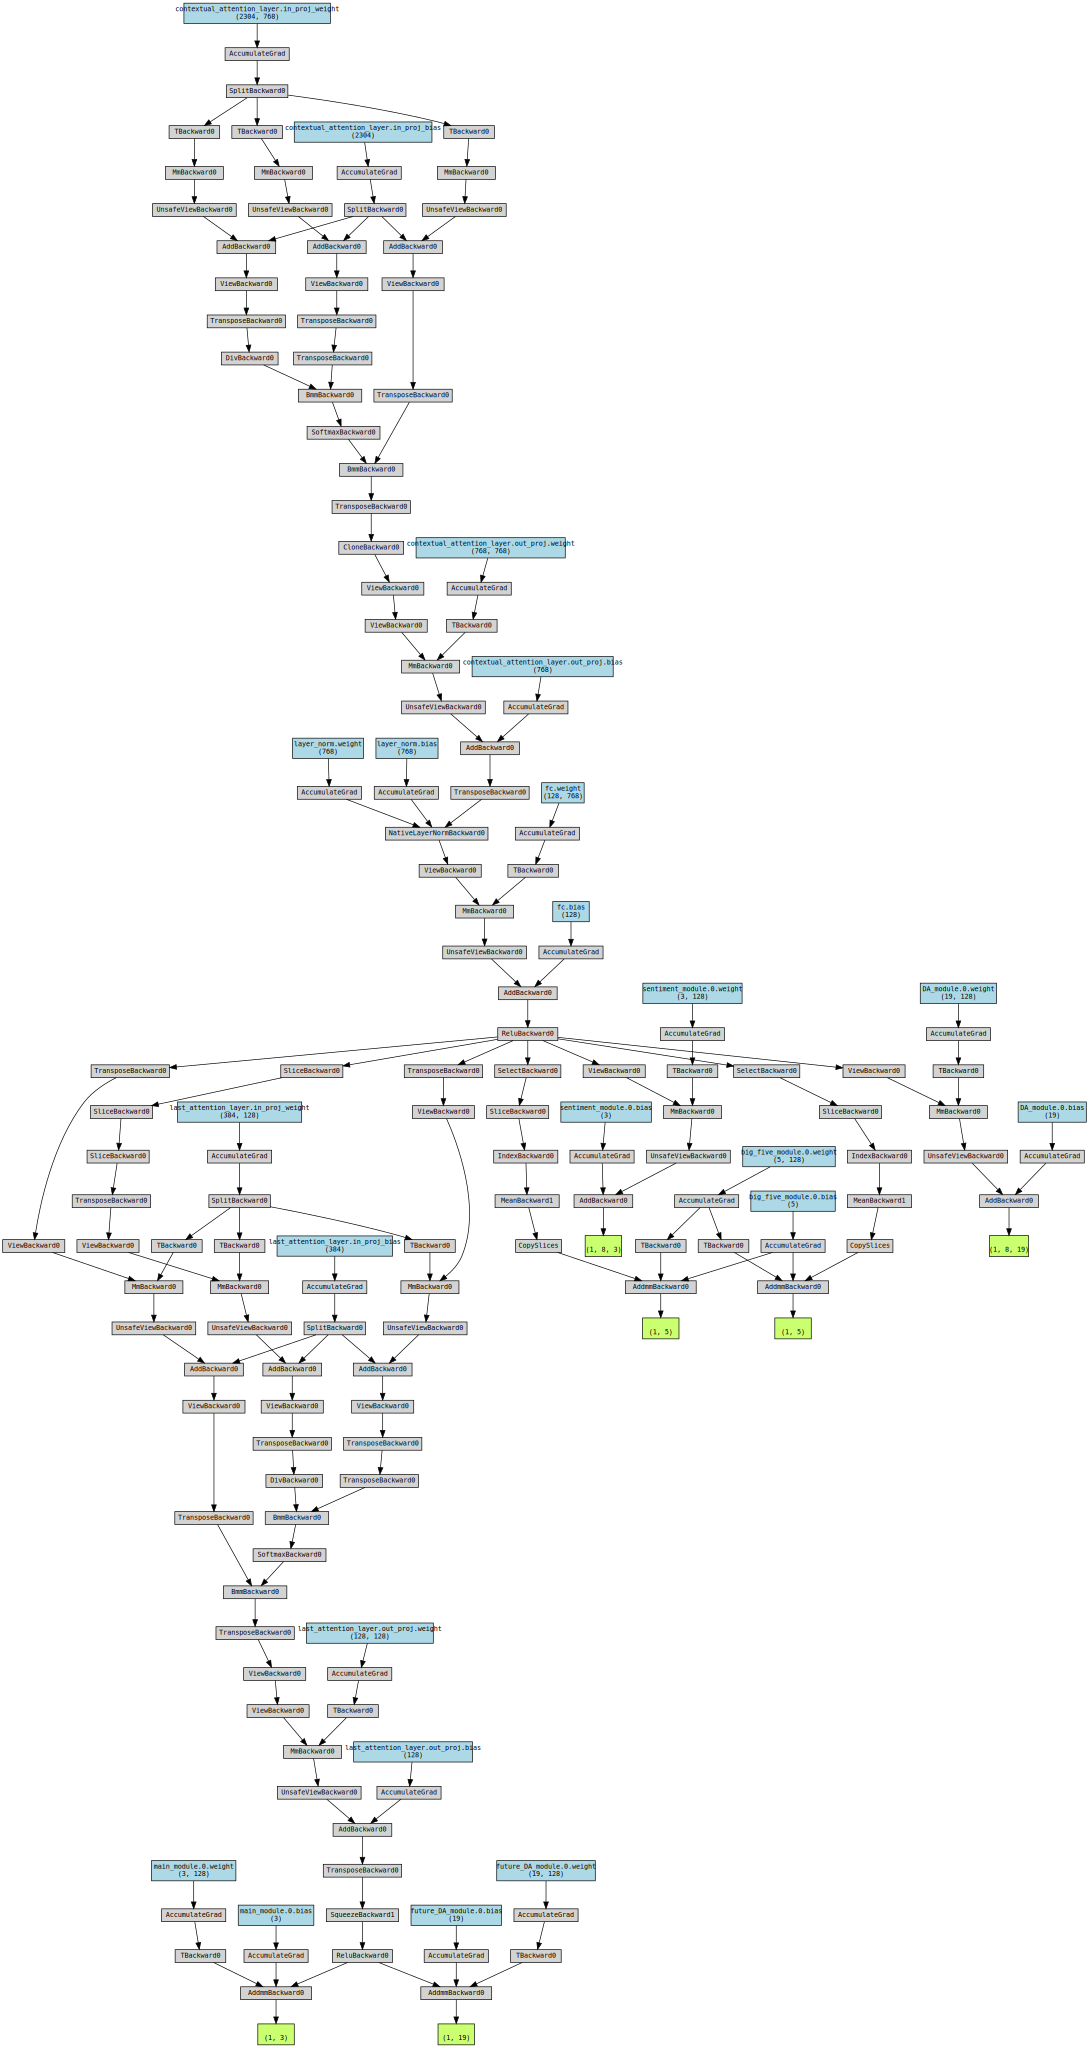

In [33]:
# Model Architecture
my_utils.plot_model_architecture(model, DEVICE)

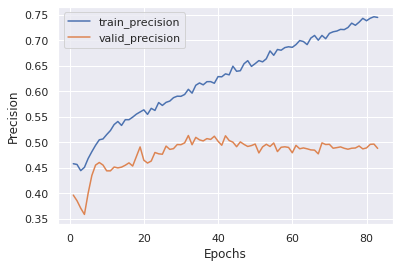

In [34]:
# Precision
my_utils.plot_result([train_precision_list], [valid_precision_list], ["precision"])

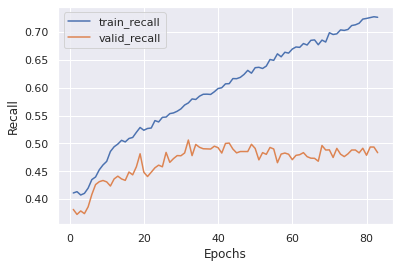

In [35]:
# Recall
my_utils.plot_result([train_recall_list], [valid_recall_list], ["recall"])

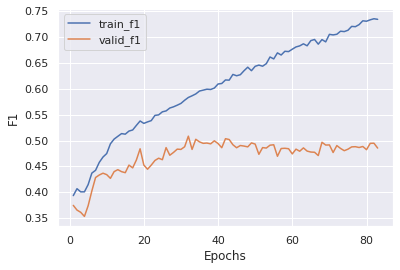

In [36]:
# F1-Score
my_utils.plot_result([train_f1_list], [valid_f1_list], ["f1"])

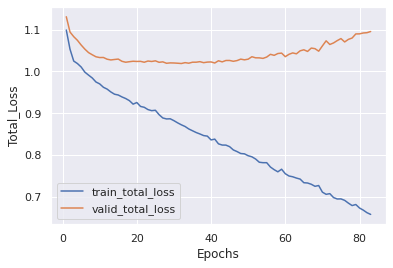

In [37]:
# Total Loss
my_utils.plot_result([train_loss_dict["total_loss"]], [valid_loss_dict["total_loss"]], ["total_loss"])

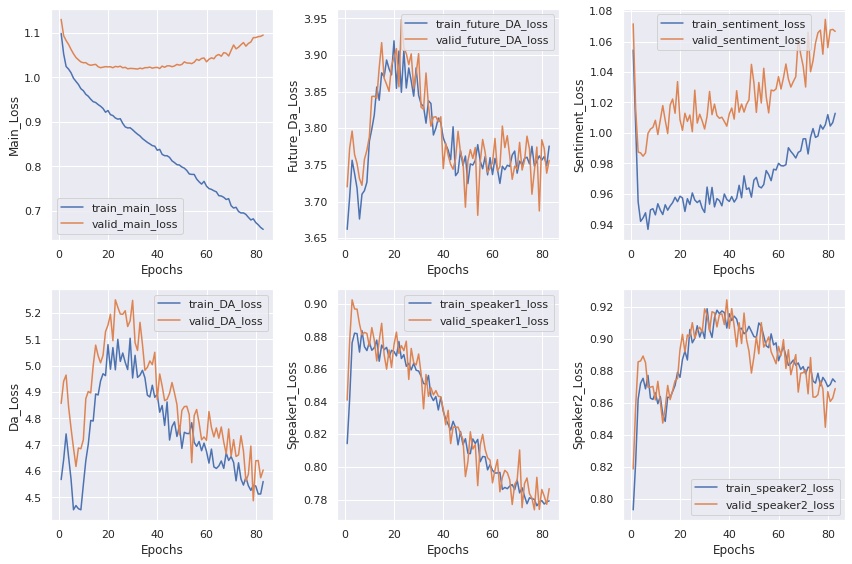

In [38]:
# Loss
assert train_loss_dict.keys() == valid_loss_dict.keys()
my_utils.plot_result(list(train_loss_dict.values()), list(valid_loss_dict.values()), list(train_loss_dict.keys()))

# Model Testing

In [39]:
def test(model):

    # Test Dataset
    test = Dataset(df=test_df, embeddings=test_embedding)
    
    # Test DataLoader
    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

    # Run the model on GPU
    model = model.to(DEVICE)
        
    # Set the state of the model to "Evaluation"
    model.eval()

    # To save the test result
    test_true = torch.tensor([])
    test_pred = torch.tensor([])

    # Test
    with torch.no_grad():

        # Test with batches
        for test_embeddings, test_main_labels, _, _, _, _, _, test_speaking_order in tqdm(test_dataloader):

            # Feed the data into the model
            test_embeddings = test_embeddings.to(DEVICE)
            test_main_labels = test_main_labels.to(DEVICE)
            test_speaking_order = test_speaking_order.to(DEVICE)
            main_output, _, _, _, _, _ = model(test_embeddings, test_speaking_order)
            main_output = torch.squeeze(main_output)
            
            # Calculate Score
            test_main_labels = test_main_labels.cpu()
            main_output = torch.argmax(main_output, dim=-1).cpu()

            # Save the result of each batch
            test_true = torch.cat([test_true, test_main_labels])
            test_pred = torch.cat([test_pred, main_output])

        # Calculate Metrics
        test_accuracy = accuracy_score(test_true, test_pred)
        test_precision = precision_score(test_true, test_pred, average='macro')
        test_recall = recall_score(test_true, test_pred, average='macro')
        test_f1 = f1_score(test_true, test_pred, average='macro')
        
    print(f"test_accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"test_precision: {round(test_precision * 100, 2)}%")
    print(f"test_recall: {round(test_recall * 100, 2)}%")
    print(f"test_f1: {round(test_f1 * 100, 2)}%")
    
    # Draw the result
    my_utils.plot_report(test_true, test_pred, list(LABEL_MAPPING.keys()))
    my_utils.plot_confusion_matrix(test_true, test_pred, list(LABEL_MAPPING.values()), list(LABEL_MAPPING.keys()))
        
    return test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred

In [40]:
model = Model()
if WITH_TRAINING:
    model.load_state_dict(torch.load(FINETUNED_MODEL_PATH))
else:
    model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))

100%|██████████| 11/11 [00:00<00:00, 56.34it/s]


test_accuracy: 42.61%
test_precision: 42.77%
test_recall: 39.82%
test_f1: 37.82%
              precision    recall  f1-score   support

     neutral     0.4381    0.7046    0.5402       281
    negative     0.5258    0.2016    0.2914       253
    positive     0.3191    0.2885    0.3030       156

    accuracy                         0.4261       690
   macro avg     0.4277    0.3982    0.3782       690
weighted avg     0.4433    0.4261    0.3954       690



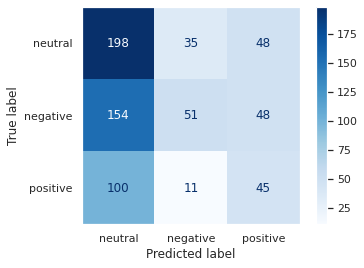

In [41]:
test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred = test(model)

In [42]:
reverse_mapping = {v: k for k, v in LABEL_MAPPING.items()}
for i in range(300):
    print(test_df.context[i])
    t, p = test_df.labels[i]['main_label'], int(test_pred[i])
    flag = "X" if t != p else ""
    print(f"True: {reverse_mapping[t]} ({t})")
    print(f"Pred: {reverse_mapping[p]} ({p}) {flag}")
    print(f"Next Sentence: {test_df.demo[i]}")
    print("="*70)

['語者一：欸欸下週旅行要怎麼去啊', '語者一：要不要一起搭高鐵', '語者二：蛤可是高鐵很貴欸', '語者二：我最近好窮', '語者一：有學生票啊', '語者一：折很多吧', '語者二：也才85折而已還是好貴', '語者二：還是我們就搭客運啊']
True: negative (1)
Pred: positive (2) X
Next Sentence: 不要啦客運很久欸
['語者一：蛤可是高鐵很貴欸', '語者一：我最近好窮', '語者二：有學生票啊', '語者二：折很多吧', '語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 但這樣好貴我不想花那麼多錢
['語者一：我最近好窮', '語者二：有學生票啊', '語者二：折很多吧', '語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了', '語者一：但這樣好貴我不想花那麼多錢']
True: neutral (0)
Pred: neutral (0) 
Next Sentence: 那不然我們搭早一點的
['語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了', '語者一：但這樣好貴我不想花那麼多錢', '語者二：那不然我們搭早一點的', '語者二：五折的那種勒', '語者二：這樣我們還可以早點去玩']
True: neutral (0)
Pred: neutral (0) 
Next Sentence: 好像也不是不行
['語者一：不要啦客運很久欸', '語者一：搭過去一天就都沒了', '語者二：但這樣好貴我不想花那麼多錢', '語者一：那不然我們搭早一點的', '語者一：五折的那種勒', '語者一：這樣我們還可以早點去玩', '語者二：好像也不是不行', '語者二：那你先查查看有幾點有五折票']
True: neutral (0)
Pred: neutral (0) 
Next Sentence: 好我看一下
['語者一：但這樣好貴我不想花那麼多錢', '語

True: neutral (0)
Pred: positive (2) X
Next Sentence: 那我可以先看看內容物嗎
['語者一：怎麼會', '語者一：這可是我們最新跟偶像男團合作的養成系桌遊', '語者二：可是他的包裝看起來就很醜阿', '語者一：那可能是每個人的審美差異', '語者一：包裝是因為跟合作方談過的', '語者一：而且內容是相當有趣精彩的', '語者一：保證不會讓你失望', '語者二：那我可以先看看內容物嗎']
True: positive (2)
Pred: neutral (0) X
Next Sentence: 當然沒問題
['語者一：包裝是因為跟合作方談過的', '語者一：而且內容是相當有趣精彩的', '語者一：保證不會讓你失望', '語者二：那我可以先看看內容物嗎', '語者一：當然沒問題', '語者一：裡面有各種角色卡', '語者一：你可以擔任他的經紀人', '語者一：就當作你在經營一個男團']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 蛤我不感興趣誒
['語者一：而且內容是相當有趣精彩的', '語者一：保證不會讓你失望', '語者二：那我可以先看看內容物嗎', '語者一：當然沒問題', '語者一：裡面有各種角色卡', '語者一：你可以擔任他的經紀人', '語者一：就當作你在經營一個男團', '語者二：蛤我不感興趣誒']
True: neutral (0)
Pred: neutral (0) 
Next Sentence: 如果你對於經營沒有甚麼興趣的話裡面也有對戰機制
['語者一：保證不會讓你失望', '語者二：那我可以先看看內容物嗎', '語者一：當然沒問題', '語者一：裡面有各種角色卡', '語者一：你可以擔任他的經紀人', '語者一：就當作你在經營一個男團', '語者二：蛤我不感興趣誒', '語者一：如果你對於經營沒有甚麼興趣的話裡面也有對戰機制']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 我還是覺得算了
['語者一：當然沒問題', '語者一：裡面有各種角色卡', '語者一：你可以擔任他的經紀人', '語者一：就當作你在經營一個男團', '語者二：蛤我不感興趣誒', '語者一：如果你對

In [43]:
# Test Directly: 37.82%
# w/ Finetune: 50.36%
# Train from scratch: 49.89%
# w/ Domain Adversarial Training: 35.83%